In [2]:
import torch
import sys
import timm
from timm.models.vision_transformer import VisionTransformer  
from src.callbacks import ReconstructionLogger
import torch
from matplotlib import pyplot as plt

In [ ]:
from datasets import load_dataset
load_dataset()

In [7]:
m = timm.create_model(
    "vit_base_patch16_224",
    img_size=224,
    num_classes=1000,
    global_pool="avg",
    class_token=True,
    pretrained=True,
    pretrained_cfg_overlay={"file": "../../artifacts/model-2knf0d16:v0/backbone.ckpt"},
    pretrained_strict=False,
)

Unexpected keys (norm.weight, norm.bias) found while loading pretrained weights. This may be expected if model is being adapted.


In [4]:
m.embed_dim

768

In [61]:
def load_part():
    from functools import partial
    from src.models.part_vit_module_v3 import PARTModule

    path = "../../artifacts/model-2knf0d16:v0/epoch=108-step=68234.ckpt"  #@param {type:"string"}
    # reassign src.models.components.part_utils to src.models.components.utils.part_utils
    # import sys
    # sys.modules['src.models.components.part_utils'] = sys.modules['src.models.components.utils.part_utils']
    back = PARTModule.load_from_checkpoint(path, strict=False)
    return back.cuda().eval()

In [ ]:
model = load_part().net.eval()

/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [4]:
x = torch.randn(1, 3, 224, 224).cuda()

In [25]:
# set seed
torch.manual_seed(0)
# forward hook all blocks 
blocks_ios = []
def hook_block(block, input, output):
    blocks_ios.append((input, output))
for block in model.blocks:
    block.register_forward_hook(hook_block)

patch_embed = None
# hook patch_embed
def hook_patch_embed(block, input, output):
    global patch_embed
    patch_embed = (input, output)

model.patch_embed.register_forward_hook(hook_patch_embed)

with torch.no_grad():
    outs = model.forward_encoder(x, 0, 0)
    ids_restore = outs["ids_restore"]
    zz = outs["z"]


In [36]:
zz.shape

torch.Size([1, 197, 768])

In [ ]:
# apply ids restore to outs!!!!
zzzz = torch.gather(zz[:, 1:, :], 1, ids_restore.unsqueeze(-1).repeat(1, 1, zz.size(-1)))
zzzz.shape

torch.Size([1, 196, 768])

In [39]:
zzzz[0][:3][:10]

tensor([[ 0.6875,  0.9817,  ...,  1.4602,  0.3650],
        [ 1.8483, -0.2674,  ...,  0.8675,  0.6909],
        [ 0.9077,  0.6684,  ...,  1.3948,  0.3071]], device='cuda:0')

In [53]:
mask = torch.isclose(zzzz, z[3][:, 1:, :], atol=1e-6)

In [59]:
print(zzzz[~mask])
print(z[3][:, 1:, :][~mask])

tensor([ 0.0116,  0.0088, -0.0220,  0.0077,  0.0067,  0.0186, -0.0179, -0.0308,
        -0.0068, -0.0174, -0.0084,  0.0048, -0.0028], device='cuda:0')
tensor([ 0.0116,  0.0088, -0.0220,  0.0077,  0.0067,  0.0186, -0.0179, -0.0308,
        -0.0068, -0.0174, -0.0084,  0.0048, -0.0028], device='cuda:0')


In [41]:
# set seed
torch.manual_seed(0)
z = dict()
with torch.no_grad():
    z[0] = model.patch_embed(x)
    z[1] = model._pos_embed(z[0])
    z[2] = z[1]
    for blk in model.blocks:
        z[2] = blk(z[2])
    z[3] = model.norm(z[2])


In [42]:
for zzz in z.values():
    print(zzz[0][:3][:10])

tensor([[-1.2664,  0.2989,  ..., -0.6423, -1.4126],
        [ 0.6245,  0.0774,  ...,  1.3887,  0.5929],
        [-0.6802, -0.0655,  ...,  0.3966,  2.3915]], device='cuda:0')
tensor([[-0.0234,  0.0314,  ..., -0.0272,  0.0242],
        [-1.2664,  0.2989,  ...,  0.3577, -0.4126],
        [ 1.4660,  0.8927,  ...,  2.3887,  1.5929]], device='cuda:0')
tensor([[ 2.3651, -0.7918,  ...,  2.5184, -2.0639],
        [ 3.0562,  4.0383,  ...,  5.7933,  1.7961],
        [ 6.1449, -0.3121,  ...,  3.1921,  2.5949]], device='cuda:0')
tensor([[ 0.3718, -0.1425,  ...,  0.4208, -0.3604],
        [ 0.6875,  0.9817,  ...,  1.4602,  0.3650],
        [ 1.8483, -0.2674,  ...,  0.8675,  0.6909]], device='cuda:0')


In [32]:
torch.isclose(zz, z[3])

tensor([[[ True,  True,  ...,  True,  True],
         [False, False,  ..., False, False],
         ...,
         [False, False,  ..., False, False],
         [False, False,  ..., False, False]]], device='cuda:0')

In [13]:
z[3][0][0][:10]

tensor([ 0.3718, -0.1425, -0.0351,  0.2427, -0.1272,  0.0483,  0.6671, -0.0810,
         0.1436, -0.1863], device='cuda:0')

In [14]:
vit = timm.create_model("vit_base_patch16_224", pretrained=False).cuda().eval()

In [15]:
filter_fn = lambda k: not k.startswith("decoder") and not k == "mask_pos_token"
state_dict  = model.state_dict()
state_dict = {k: v for k, v in state_dict.items() if filter_fn(k)}
vit.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])

In [83]:
# save state_dict
torch.save(state_dict, f"../../artifacts/model-2knf0d16:v0/backbone.cpkt")

In [16]:
torch.manual_seed(0)
with torch.no_grad():
    out = vit.forward_features(x)

In [17]:
out

tensor([[[ 0.3718, -0.1425, -0.0351,  ..., -0.2404,  0.4208, -0.3604],
         [ 0.6875,  0.9817, -0.9988,  ..., -0.2493,  1.4602,  0.3650],
         [ 1.8483, -0.2674,  0.2351,  ...,  0.7771,  0.8675,  0.6909],
         ...,
         [ 0.5627,  0.0845,  0.4963,  ..., -0.2032,  0.2466,  0.3506],
         [-0.3681, -0.9040, -0.3943,  ...,  0.2978,  0.9789,  0.5540],
         [-0.1632, -0.6162, -0.2253,  ..., -0.3587,  1.4548,  0.1161]]],
       device='cuda:0')

In [18]:
# assert that out and z[3] are the same
print(torch.allclose(out, z[3], atol=1e-6))

True


In [62]:
module = load_part()

/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [78]:
module.net.mask_ratio=0
module.net.pos_mask_ratio=0.75

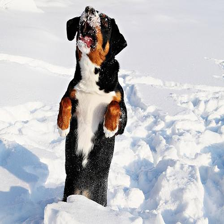

In [79]:
from PIL import Image
img = Image.open("../../artifacts/dog.jpg").convert("RGB").resize((224, 224))
img.show()
img

/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(


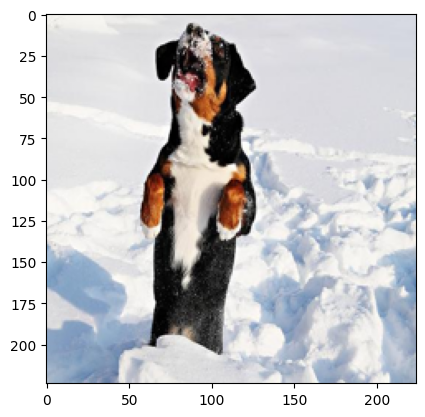

In [80]:
# batch = datamodule.hparams.test_transform(img)
from torchvision.transforms.v2.functional import to_image, to_tensor
batch = to_tensor(img)
# plot batch
plt.imshow(batch.permute(1, 2, 0))


In [81]:
with torch.no_grad():
    output = module.model_step({"image": batch.unsqueeze(0).cuda()})



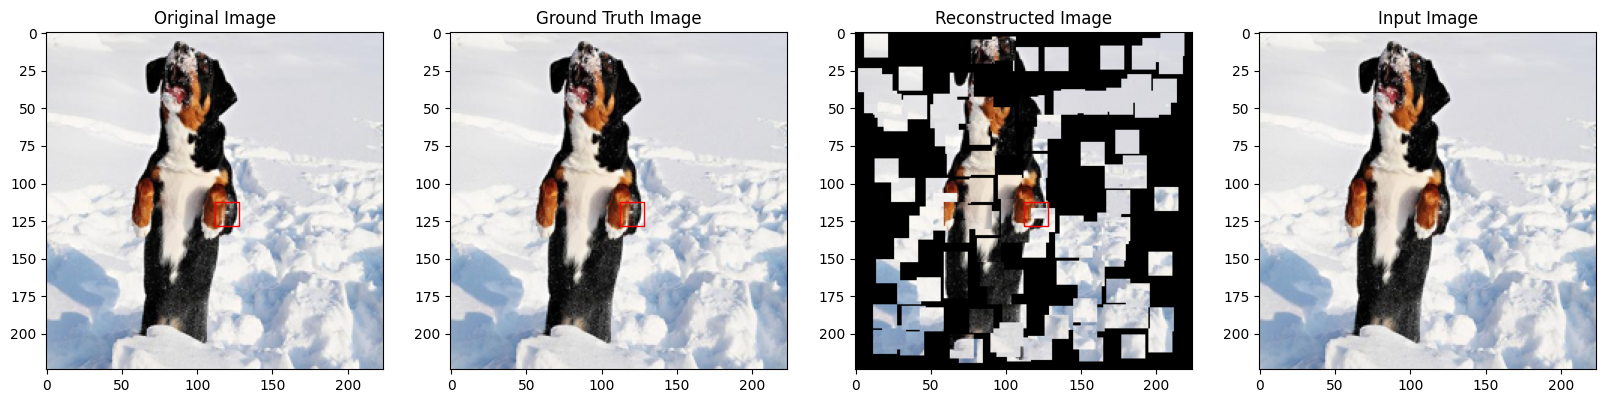

In [82]:
callback = ReconstructionLogger(-1, num_samples=4)
fig_rec, fig_prov = callback._plot(
    module,
    output["x_original"].detach().cpu(),
    output["x"].detach().cpu(),
    output["patch_positions"].detach().cpu(),
    output["pred_T"].detach().cpu(),
    output["patch_pair_indices"].detach().cpu(),
    output["ids_nopos"].detach().cpu()
)
plt.close(fig_prov)
